In [97]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMAResults

# Data Processing 

In [98]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)

In [99]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [100]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [101]:
daily_sales = daily_sales[913:]
daily_expenses = daily_expenses[1044:]
monthly_sales = monthly_sales[15:]
monthly_expenses = monthly_expenses[20:]

In [102]:
print(len(monthly_expenses), len(monthly_sales))
print(len(daily_expenses), len(daily_sales))

23 23
28 28


In [103]:
category1 = daily_sales
category2 = daily_expenses
category3 = monthly_sales
category4 = monthly_expenses
category = category3

category = pd.DataFrame(category)
category.reset_index(inplace=True)
category =category['Amount']

# Remove Outliers

In [104]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(12)

# Scaling

In [105]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# category1 = scaler.fit_transform(category1)

# PCA

In [106]:
n = 1
pca = PCA(n_components=n)
principal_components = pca.fit_transform(category.values.reshape(-1,1))
category = pd.DataFrame(data=principal_components, columns=['PC1'])
category

,PC1
0,1154531.5
1,-7675509.5
2,1997266.5
3,1056875.5
4,-2228326.5
5,-5959539.5
6,4124232.5
7,5851388.5
8,-1277989.5
9,-6995122.5


In [107]:
# category = category1

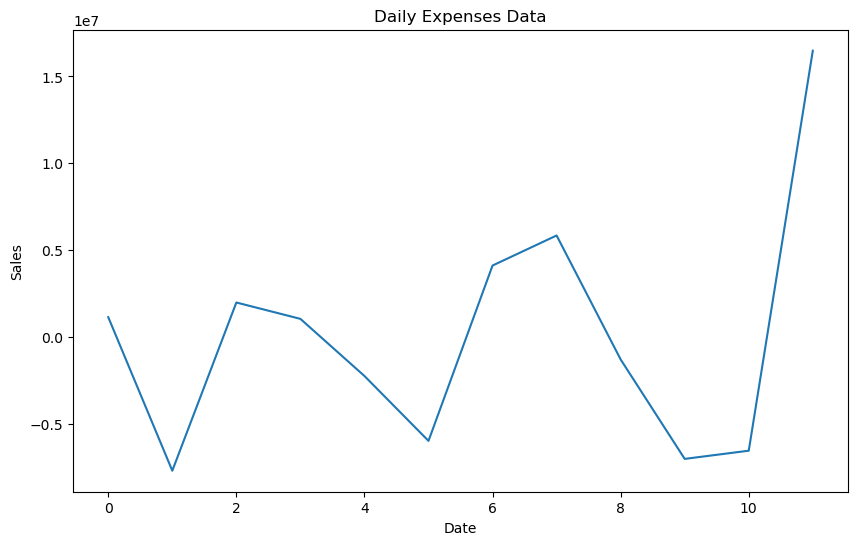

In [108]:
plt.figure(figsize=(10,6))
plt.plot(category)
plt.title('Daily Expenses Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [109]:
len(category)

12

In [110]:
# category = category.flatten()
category = pd.DataFrame(category)
category

,PC1
0,1154531.5
1,-7675509.5
2,1997266.5
3,1056875.5
4,-2228326.5
5,-5959539.5
6,4124232.5
7,5851388.5
8,-1277989.5
9,-6995122.5


# Train-Test Split

In [111]:
msk = (category.index < len(category) - 4) # The last x data points as test
category_train = category[msk].copy()
category_test = category[~msk]

# Check for Stationarity

ACF and PACF plot

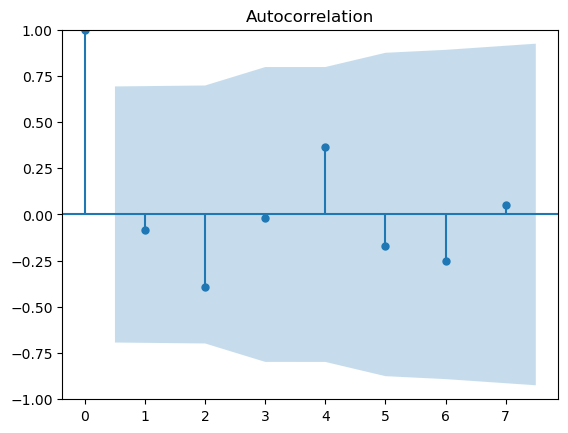

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(category_train)
# pacf_original = plot_pacf(category_train)

In [113]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num of lags : ", dftest[2])
    print("4. Num of observations used for ADF regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

In [114]:
# ad_test(edf_monthly['expenseAmount'])
ad_test(category_train)

1. ADF :  -1.8794352375212546
2. P-Value :  0.3417963989325864
3. Num of lags :  2
4. Num of observations used for ADF regression and Critical Values Calculation :  5
5. Critical Values : 
	 1% : -6.045114
	 5% : -3.9292800000000003
	 10% : -2.98681


Differencing

In [115]:
# category1=category.diff().dropna()

# Fit the model

Determine the model's parameters

In [116]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [117]:
p=3
d=0
q=1

In [118]:
# model1=SARIMAX(category_train, order=(p,d,q))
# dailyExpenses=ARIMA(category_train, order=(p,d,q))
monthlySales=ARIMA(category_train, order=(p,d,q))
# model4=ARIMA(category_train, order=(p,d,q))

In [119]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(dailySales, f)
# result1 = model1.fit()
# print(result.summary())

In [120]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(dailyExpenses, f)
# result = dailyExpenses.fit()
# print(result.summary())

In [121]:
with open('monthlySales.pk1', 'wb') as f:
    pickle.dump(monthlySales, f)
result3 = monthlySales.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                    PC1   No. Observations:                    8
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -131.285
Date:                Thu, 09 May 2024   AIC                            274.570
Time:                        19:10:34   BIC                            275.047
Sample:                             0   HQIC                           271.355
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.099e+05   9.45e+05     -0.222      0.824   -2.06e+06    1.64e+06
ar.L1         -0.9411      0.968     -0.972      0.331      -2.839       0.957
ar.L2         -0.8904      0.567     -1.571      0.1

In [122]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(monthlyExpenses, f)
# result4 = model4.fit()
# print(result.summary())

In [123]:
category1[:1]

,Amount
date,
2023-10-10,1168275


In [124]:
start=len(category1[:1])
end=len(category3)
pred = result3.predict(start=start, end=end, typ='levels')
print(pred)

1    -3.526941e+05
2     1.443476e+05
3     4.191509e+06
4     4.781793e+05
5    -2.661215e+06
6     4.099159e+06
7     2.353108e+06
8    -3.390542e+06
9    -5.850232e+06
10    3.403385e+06
11    3.787155e+06
12   -2.976246e+06
13   -3.863841e+06
14    2.706778e+06
15    2.364677e+06
16   -2.500820e+06
17   -2.524481e+06
18    2.085370e+06
19    1.401879e+06
20   -2.041728e+06
21   -1.635193e+06
22    1.558760e+06
23    7.628012e+05
Name: predicted_mean, dtype: float64


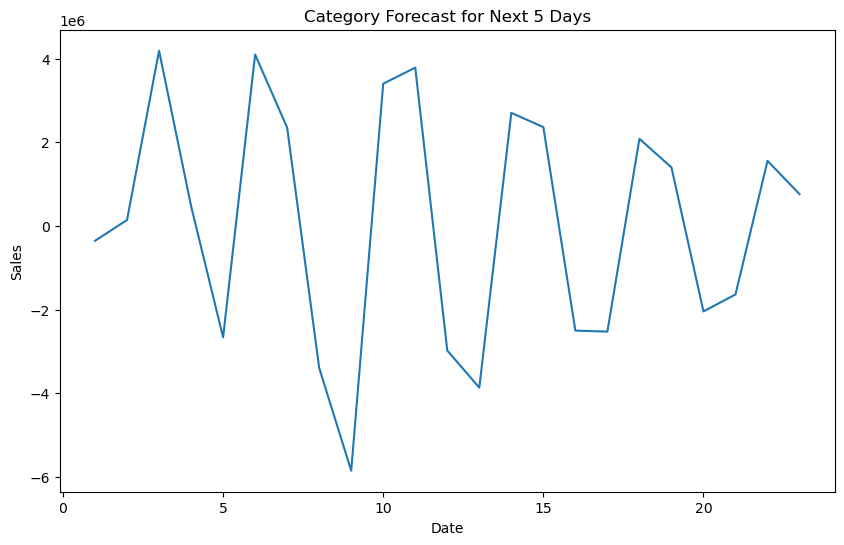

In [125]:
plt.figure(figsize=(10,6))
plt.plot(pred, label='Predicted data')
# plt.plot(category1, label='Original Data')
plt.title('Category Forecast for Next 5 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [126]:
forecast_steps = 5
predict = result3.forecast(steps=forecast_steps)
forecast_steps=str(forecast_steps)

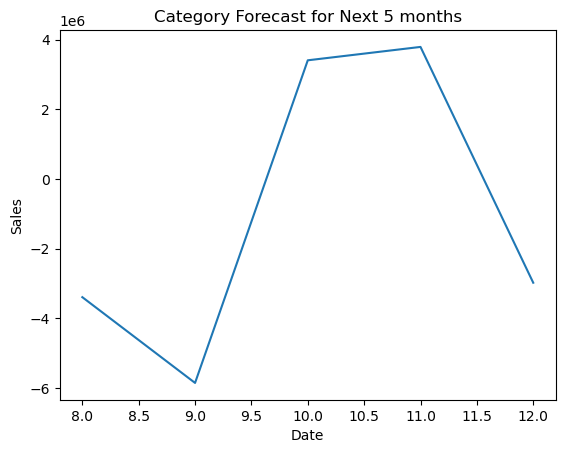

In [127]:
# plt.plot(category1, label='Original Data')
plt.plot(predict, label='Forecast')
plt.title('Category Forecast for Next' +' '+ forecast_steps +' '+ 'months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Evaluate Model

In [128]:
pred.mean()

66961.6723113639

In [33]:
forecast_test = result.forecast(len(category_test))
forecast_test

24    11657.806395
25   -13515.871322
26      980.057360
27     7507.890011
Name: predicted_mean, dtype: float64

In [51]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(category_test, forecast_test)
mape = mean_absolute_percentage_error(category_test, forecast_test)
rmse =  np.sqrt(mean_squared_error(category_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 64452.97812762142
mape - manual: 0.9598337928074132
rmse - manual: 67838.2731750429


In [20]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings("ignore")

In [21]:
# stepwise_fit = auto_arima(category, seasonal=True, stepwise=True, approximation=False, m=4, trace=True, supress_warnings=True)
# stepwise_fit.summary()